# Calculating Absolute Error Values using Trial Datasets

# Reading packages 


In [1]:
# Importing necessary packages for data analysis
import re
from datetime import datetime
import pandas as pd
import datetime as dt

# Reading trial dataset


In [2]:
# Reading one of trial datasets (There are 5 trial datasets in total)
# You need to change the name of trial dataset below and run the code to read each trial dataset and then run the rest of the code below for each trial dataset separately
data = pd.read_csv("Test11-rpi26.csv",dtype='unicode')
data = data.sort_values(by=['time_seen', 'entry_id'],ascending=True)
rssis = data.rssi.to_list()
rssis = list(map(int, rssis))
data



,entry_id,beacon_id,rssi,time_seen,rpi_id,distance
0,18219217,82,-78,2016-10-17 00:44:41,rpi-26,8.53
1,18219253,82,-96,2016-10-17 00:44:42,rpi-26,8.53
2,18219311,82,-74,2016-10-17 00:44:44,rpi-26,8.53
3,18219336,82,-89,2016-10-17 00:44:45,rpi-26,8.53
4,18219371,82,-83,2016-10-17 00:44:46,rpi-26,8.53
...,...,...,...,...,...,...
780,18243438,82,-87,2016-10-17 00:59:49,rpi-26,8.53
781,18243466,82,-87,2016-10-17 00:59:50,rpi-26,8.53
782,18243489,82,-69,2016-10-17 00:59:51,rpi-26,8.53
783,18243506,82,-93,2016-10-17 00:59:52,rpi-26,8.53


#  Finding 10 sec windows for user

In [3]:
def finding_time_window_for_each_user(window_size):
    head = 0
    ptr = head
    time_windows = {}
    counter = 0
    last_time = pd.to_datetime(data["time_seen"].iloc[-1])
    first_time = pd.to_datetime(data["time_seen"].iloc[0])
    interval = last_time - first_time
    interval = interval.total_seconds()
    number_of_windows = interval / window_size
    iter_times = int(len(data['time_seen']) / number_of_windows)


    #ptr <= len(data['time_seen']) - 1- iter_times
    while  ptr <= len(data['time_seen']) -1:
      


        duration = 0
        ptr = head + 1
        # time_intervals = []
        tmp_observed_timeSeen = []
        start_time = data["time_seen"].iloc[head]
        tmp_observed_timeSeen.append(start_time)
        start_time = pd.to_datetime(start_time)

        tmp_observed_rssis = []
        start_rssi = data["rssi"].iloc[head]
        tmp_observed_rssis.append(int(start_rssi))

        while duration <= window_size and ptr <= len(data['time_seen']) - 1:

            if (duration == window_size):
                #time_intervals = tmp_observed_timeSeen
                #time_windows['Time Window {}'.format(counter)] = [time_intervals[0], time_intervals[-1]]
                time_windows['Time Window {}'.format(counter)] = tmp_observed_rssis
                #time_windows['Time Window {}'.format(counter)] = data[head:ptr]

                head = ptr
                counter = counter + 1
                break

            else:

                end_time = data["time_seen"].iloc[ptr]
                tmp_observed_timeSeen.append(end_time)
                end_time = pd.to_datetime(end_time)
                duration = end_time - start_time
                duration = duration.total_seconds()

                end_rssi = data["rssi"].iloc[ptr]
                tmp_observed_rssis.append(int(end_rssi))

                ptr = ptr + 1

        if (duration > window_size):
            head = head + 1
            # continue

    return time_windows


out = finding_time_window_for_each_user(10)
print(out)
print(len(out))


{'Time Window 0': [-78, -96, -74, -89, -83, -77, -69, -67, -75], 'Time Window 1': [-69, -68, -87, -76, -81, -69, -76, -84, -84, -73], 'Time Window 2': [-86, -72, -69, -70, -84, -82, -77, -76, -72, -85], 'Time Window 3': [-67, -84, -70, -70, -71, -83, -71, -73, -86, -72], 'Time Window 4': [-69, -85, -73, -72, -69, -74, -69, -84, -73, -70, -73], 'Time Window 5': [-84, -74, -84, -84, -73, -72, -73, -84, -72], 'Time Window 6': [-74, -83, -85, -84, -72, -70, -86, -74, -72, -73], 'Time Window 7': [-73, -86, -73, -86, -72, -85, -74, -78, -74, -86], 'Time Window 8': [-71, -86, -84, -86, -71, -84, -74, -71, -76], 'Time Window 9': [-69, -73, -85, -70, -73, -86, -85, -86, -74, -73], 'Time Window 10': [-73, -74, -84, -72, -73, -73, -85, -73, -73], 'Time Window 11': [-73, -73, -72, -83, -85, -86, -72, -70, -86, -84], 'Time Window 12': [-84, -72, -84, -73, -84, -70, -73, -83, -73], 'Time Window 13': [-84, -73, -85, -74, -85, -84, -84], 'Time Window 14': [-86, -74, -75, -85, -72, -69, -74, -73, -84, 

# Calculate Distance from the RSSI value of the BLE Beacon

In [5]:
import math

def getDistance(rssi):
    p_d0 = -64.63
    alpha = 0.8891
    ratio = (rssi - p_d0)/(-10 * alpha )
    distance = math.pow(10 , ratio)
    distance=((int(distance*100)/float(100)))
    return distance


# Applying kalman filter with exponential smoothing for the whole time duration.


In [6]:
# import math functions
from math import *
import matplotlib.pyplot as plt
import numpy as np

# gaussian function
def f(mu, sigma2, x):
    ''' f takes in a mean and squared variance, and an input x
       and returns the gaussian value.'''
    coefficient = 1.0 / sqrt(2.0 * pi *sigma2)
    exponential = exp(-0.5 * (x-mu) ** 2 / sigma2)
    return coefficient * exponential


# the update function
def update(mean1, var1, mean2, var2):
    ''' This function takes in two means and two squared variance terms,
        and returns updated gaussian parameters.'''
    # Calculate the new parameters
    new_mean = (var2*mean1 + var1*mean2)/(var2+var1)
    new_var = 1/(1/var2 + 1/var1)
    
    return [new_mean, new_var]


# the motion update/predict function
def predict(mean1, var1, mean2, var2):
    ''' This function takes in two means and two squared variance terms,
        and returns updated gaussian parameters, after motion.'''
    # Calculate the new parameters
    new_mean = mean1 + mean2
    new_var = var1 + var2
    
    return [new_mean, new_var]



def apply_kalman_filter_to_whole_data(rssis):
    
    alpha=0.2
    measurements = []
    motions = []
    # measurements for mu and motions, U
    measurements = rssis
    motions = [0] * len(measurements)
       
    # creating motions list using exponential smoothing
    # Initialize first point of forecast
    motions.append(measurements[0])
     
    # Create all the m+1 forecast
    for t in range(1,len(measurements)-1):
        motions.append((1-alpha)*motions[-1]+alpha*measurements[t])
       
       

    # initial parameters
    measurement_sig = 4.
    motion_sig = 0.
    mu = 0.
    sig = 10000.


    ## TODO: Loop through all measurements/motions
    # this code assumes measurements and motions have the same length
    # so their updates can be performed in pairs
    for n in range(len(measurements)):
        # measurement update, with uncertainty
        mu, sig = update(mu, sig, measurements[n], measurement_sig)
        # motion update, with uncertainty
        mu, sig = predict(mu, sig, motions[n], motion_sig)
           
    
    return int(mu)
    

    
estimated_rssi = apply_kalman_filter_to_whole_data(rssis)
out1 = getDistance(estimated_rssi)
out1


24.62

# Applying kalman filter with exponential smoothing in each time window.

In [7]:
# import math functions
from math import *
import matplotlib.pyplot as plt
import numpy as np

# gaussian function
def f(mu, sigma2, x):
    ''' f takes in a mean and squared variance, and an input x
       and returns the gaussian value.'''
    coefficient = 1.0 / sqrt(2.0 * pi *sigma2)
    exponential = exp(-0.5 * (x-mu) ** 2 / sigma2)
    return coefficient * exponential


# the update function
def update(mean1, var1, mean2, var2):
    ''' This function takes in two means and two squared variance terms,
        and returns updated gaussian parameters.'''
    # Calculate the new parameters
    new_mean = (var2*mean1 + var1*mean2)/(var2+var1)
    new_var = 1/(1/var2 + 1/var1)
    
    return [new_mean, new_var]


# the motion update/predict function
def predict(mean1, var1, mean2, var2):
    ''' This function takes in two means and two squared variance terms,
        and returns updated gaussian parameters, after motion.'''
    # Calculate the new parameters
    new_mean = mean1 + mean2
    new_var = var1 + var2
    
    return [new_mean, new_var]





def apply_kalman_with_expo_to_time_window(out):
    user_kalman_filter_rssi_dict = {}
    alpha=0.2
    
    for tw, rssis in out.items():
        measurements = []
        motions = []
        
        # measurements for mu and motions, U
        rssis = list(map(int, rssis)) 
        measurements = rssis
        motions = [0] * len(measurements)
       
        # creating motions list using exponential smoothing
        # Initialize first point of forecast
        motions.append(measurements[0])
     
        # Create all the m+1 forecast
        for t in range(1,len(measurements)-1):
            motions.append((1-alpha)*motions[-1]+alpha*measurements[t])
       
       

        # initial parameters
        measurement_sig = 4.
        motion_sig = 0.
        mu = 0.
        sig = 10000.


        ## TODO: Loop through all measurements/motions
        # this code assumes measurements and motions have the same length
        # so their updates can be performed in pairs
        for n in range(len(measurements)):
            # measurement update, with uncertainty
            mu, sig = update(mu, sig, measurements[n], measurement_sig)

            # motion update, with uncertainty
            mu, sig = predict(mu, sig, motions[n], motion_sig)
        
        estimated_distance_for_tw = getDistance(mu)   
        user_kalman_filter_rssi_dict[tw] = estimated_distance_for_tw
    return user_kalman_filter_rssi_dict
    

    
res1 = apply_kalman_with_expo_to_time_window(out)
a=list(res1.values())
a
    


[37.87,
 22.76,
 26.58,
 13.56,
 10.54,
 30.08,
 26.58,
 38.2,
 32.8,
 27.28,
 16.92,
 35.35,
 26.81,
 74.61,
 19.9,
 32.91,
 28.73,
 17.11,
 37.87,
 22.31,
 29.49,
 21.87,
 20.92,
 22.76,
 28.33,
 62.88,
 35.75,
 26.81,
 17.22,
 30.96,
 25.78,
 33.99,
 38.2,
 35.85,
 18.98,
 9.59,
 25.78,
 25.31,
 19.48,
 21.06,
 9.51,
 47.0,
 13.91,
 43.28,
 37.23,
 31.05,
 30.08,
 40.23,
 53.49,
 13.44,
 18.11,
 28.73,
 19.48,
 31.13,
 36.71,
 132.43,
 158.02,
 20.52,
 36.71,
 36.8,
 51.97,
 4.01,
 63.57,
 36.8,
 24.59,
 27.28,
 30.96,
 27.03,
 21.92,
 13.06,
 19.48,
 21.61,
 20.11,
 23.35,
 23.35,
 52.25,
 13.02,
 21.3,
 189.03]

# Distance Estimation for each window on raw data without filtering

In [8]:
# import math functions
from math import *
import matplotlib.pyplot as plt
import numpy as np

def findMiddle(input_list):
    middle = float(len(input_list))/2
    if middle % 2 != 0:
        return input_list[int(middle - .5)]
    else:
        return input_list[int(middle)]+ input_list[int(middle-1)] /2





def estimate_distance_on_raw_data(out):
    user_dist_dict = {}
   
    
   
    
    for tw, rssis in out.items():
      
        rssis = list(map(int, rssis)) 
        ave_rssi = sum(rssis) / len(rssis)
        #mean_rssis = findMiddle(rssis)
        #lat_rssi = rssis[0]
        
        estimated_distance_for_tw = getDistance(ave_rssi)   
     
        user_dist_dict[tw] = estimated_distance_for_tw
    return user_dist_dict
    

    
res1 = estimate_distance_on_raw_data(out)
a=list(res1.values())
a
    


[37.9,
 22.77,
 26.6,
 13.57,
 10.54,
 30.11,
 26.6,
 38.23,
 32.82,
 27.3,
 16.93,
 35.37,
 26.84,
 74.7,
 19.91,
 32.94,
 28.75,
 17.13,
 37.9,
 22.34,
 29.51,
 21.88,
 20.94,
 22.77,
 28.35,
 62.95,
 35.78,
 26.84,
 17.24,
 30.99,
 25.8,
 34.03,
 38.23,
 35.88,
 19.0,
 9.6,
 25.8,
 25.33,
 19.5,
 21.07,
 9.52,
 47.04,
 13.92,
 43.32,
 37.26,
 31.08,
 30.11,
 40.27,
 53.54,
 13.45,
 18.12,
 28.75,
 19.5,
 31.15,
 36.73,
 132.54,
 158.14,
 20.53,
 36.73,
 36.83,
 52.02,
 4.01,
 63.63,
 36.83,
 24.62,
 27.3,
 30.99,
 27.05,
 21.94,
 13.07,
 19.5,
 21.63,
 20.12,
 23.37,
 23.37,
 52.29,
 13.03,
 21.32,
 189.24]

# Absolute average distance error calculation for expo with Kalman

In [9]:
def distance_absolute_error(time_window_estimated_distance, real_distance):
    Sum = 0
    for estimated_distance in time_window_estimated_distance:
        absolute_error = abs(estimated_distance - real_distance)
        Sum = Sum + absolute_error
    ave = Sum/len(time_window_estimated_distance)
    ave = ((int(ave*100)/float(100)))
    return ave
real_distances = [8.22, 8.53, 9.14, 9.14, 11.27, 11.58, 19.81]       
a_error = distance_absolute_error(a, real_distances[6])  
print(a_error)

16.04


# Applying kalman filter with moving average smoothing for the whole time duaration.

In [10]:

# import math functions
from math import *
import matplotlib.pyplot as plt
import numpy as np

# gaussian function
def f(mu, sigma2, x):
    ''' f takes in a mean and squared variance, and an input x
       and returns the gaussian value.'''
    coefficient = 1.0 / sqrt(2.0 * pi *sigma2)
    exponential = exp(-0.5 * (x-mu) ** 2 / sigma2)
    return coefficient * exponential


# the update function
def update(mean1, var1, mean2, var2):
    ''' This function takes in two means and two squared variance terms,
        and returns updated gaussian parameters.'''
    # Calculate the new parameters
    new_mean = (var2*mean1 + var1*mean2)/(var2+var1)
    new_var = 1/(1/var2 + 1/var1)
    
    return [new_mean, new_var]


# the motion update/predict function
def predict(mean1, var1, mean2, var2):
    ''' This function takes in two means and two squared variance terms,
        and returns updated gaussian parameters, after motion.'''
    # Calculate the new parameters
    new_mean = mean1 + mean2
    new_var = var1 + var2
    
    return [new_mean, new_var]


def moving_average(a, N):
    cumsum, moving_aves = [0], []
    for i, x in enumerate(a, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            #can do stuff with moving_ave here
            moving_aves.append(moving_ave)
    return moving_aves



def apply_moving_average_to_whole_data(rssis):
    
    
    measurements = []
    motions = []
        
    # measurements for mu and motions, U
    measurements = rssis
    #motions = [0] * len(measurements)
    tmp = moving_average(measurements, len(rssis)+100)
    motions = tmp + [0] * (len(measurements) - len(tmp))
    # initial parameters
    measurement_sig = 4.
    motion_sig = 0.
    mu = 0.
    sig = 10000.


    ## TODO: Loop through all measurements/motions
    # this code assumes measurements and motions have the same length
    # so their updates can be performed in pairs
    for n in range(len(measurements)):
        # measurement update, with uncertainty
        mu, sig = update(mu, sig, measurements[n], measurement_sig)

        # motion update, with uncertainty
        mu, sig = predict(mu, sig, motions[n], motion_sig)
           
        
    return int(mu)

estimated_rssi = apply_moving_average_to_whole_data(rssis)
#print(estimated_rssi)
out2 = getDistance(estimated_rssi)
out2

24.62

# Applying moving average smoothing without kalman filter for each time window.

In [13]:

import statistics 
def moving_average(a, N):
    cumsum, moving_aves = [0], []
    for i, x in enumerate(a, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            #can do stuff with moving_ave here
            moving_aves.append(moving_ave)
    return moving_aves




def apply_moving_average_without_kalman_to_each_time_window(out):
    user_moving_average_rssi_dict = {}
    for tw, rssis in out.items():
        
        measurements = []
        
        
        # measurements for mu and motions, U
        rssis = list(map(int, rssis))
        measurements = rssis
        #motions = [0] * len(measurements)
        tmp = moving_average(measurements, 5)
        tmp_average = statistics.mean(tmp)
        #tmp_average = tmp[-1]
        estimated_distance_for_tw = getDistance(tmp_average)  
        user_moving_average_rssi_dict[tw] = estimated_distance_for_tw
    return user_moving_average_rssi_dict

res3 = apply_moving_average_without_kalman_to_each_time_window(out)

d=list(res3.values())
d


        
    

[46.79,
 26.15,
 25.04,
 13.68,
 10.05,
 26.47,
 27.78,
 36.94,
 39.24,
 39.24,
 17.49,
 43.52,
 25.92,
 68.18,
 16.02,
 26.95,
 27.07,
 13.57,
 36.12,
 27.66,
 34.47,
 25.73,
 23.99,
 19.16,
 27.92,
 66.72,
 50.31,
 29.97,
 15.24,
 30.6,
 30.51,
 55.66,
 25.7,
 51.98,
 21.71,
 6.79,
 24.98,
 22.42,
 28.02,
 17.43,
 12.81,
 30.81,
 12.23,
 51.59,
 39.92,
 32.73,
 36.12,
 38.9,
 62.54,
 16.1,
 19.71,
 20.53,
 11.22,
 35.64,
 52.36,
 157.52,
 111.39,
 21.44,
 51.21,
 27.59,
 44.43,
 4.01,
 33.94,
 65.87,
 20.22,
 27.3,
 27.87,
 20.31,
 16.78,
 17.13,
 15.44,
 20.36,
 22.89,
 27.07,
 19.16,
 50.09,
 12.1,
 16.6,
 173.96]

# Absolute average distance error calculation for moving ave without Kalman

In [14]:
def distance_absolute_error(time_window_estimated_distance, real_distance):
    Sum = 0
    for estimated_distance in time_window_estimated_distance:
        absolute_error = abs(estimated_distance - real_distance)
        Sum = Sum + absolute_error
    ave = Sum/len(time_window_estimated_distance)
    ave = ((int(ave*100)/float(100)))
    return ave
real_distances = [8.22, 8.53, 9.14, 9.14, 11.27, 11.58, 19.81]       
d_error = distance_absolute_error(d, real_distances[6])  
print(d_error)

16.99


# Applying exponential smoothing without kalman filter for each time window.

In [15]:
# import math functions
from math import *
import matplotlib.pyplot as plt
import numpy as np


def apply_expo_without_kalman_to_time_window(out):
    
    user_kalman_filter_rssi_dict = {}
    alpha=0.2
    
    for tw, rssis in out.items():
        measurements = []
        motions = []
        
        # measurements for mu and motions, U
        rssis = list(map(int, rssis)) 
        measurements = rssis
        
        motions = [0] * len(measurements)
       
        # creating motions list using exponential smoothing
        # Initialize first point of forecast
        motions.append(measurements[0])
     
        # Create all the m+1 forecast
        for t in range(1,len(measurements)-1):
            motions.append((1-alpha)*motions[-1]+alpha*measurements[t])
        #print(motions)
       
        #result = statistics.mean(motions)
        result = motions[-1]
        
        
        estimated_distance_for_tw = getDistance(result)  
        #print(estimated_distance_for_tw)
        user_kalman_filter_rssi_dict[tw] = estimated_distance_for_tw 

      


    
        
        
    return user_kalman_filter_rssi_dict
    

    
res4 = apply_expo_without_kalman_to_time_window(out)
e=list(res4.values())
e
 
    


[20.68,
 29.05,
 26.93,
 15.87,
 8.8,
 41.9,
 19.86,
 22.61,
 19.05,
 31.15,
 17.18,
 31.15,
 38.41,
 91.79,
 24.37,
 23.93,
 34.62,
 21.72,
 61.42,
 23.77,
 20.49,
 16.34,
 19.68,
 34.74,
 21.78,
 37.43,
 21.98,
 25.4,
 9.1,
 22.58,
 19.79,
 24.73,
 20.27,
 38.31,
 16.3,
 11.6,
 27.27,
 12.48,
 21.33,
 17.97,
 9.17,
 76.42,
 18.24,
 58.53,
 59.57,
 20.01,
 31.76,
 25.25,
 52.66,
 15.69,
 26.72,
 16.94,
 12.32,
 27.7,
 40.69,
 143.99,
 122.73,
 27.19,
 32.72,
 46.68,
 41.06,
 3.43,
 93.76,
 38.13,
 19.47,
 23.01,
 36.59,
 17.12,
 17.34,
 18.97,
 13.04,
 32.45,
 29.33,
 16.85,
 35.5,
 96.04,
 6.3,
 17.49,
 106.0]

# Absolute average distance error calculation for expo without Kalman

In [16]:
def distance_absolute_error(time_window_estimated_distance, real_distance):
    Sum = 0
    for estimated_distance in time_window_estimated_distance:
        absolute_error = abs(estimated_distance - real_distance)
        Sum = Sum + absolute_error
    ave = Sum/len(time_window_estimated_distance)
    ave = ((int(ave*100)/float(100)))
    return ave
real_distances = [8.22, 8.53, 9.14, 9.14, 11.27, 11.58, 19.81]       
e_error = distance_absolute_error(e, real_distances[6])  
print(e_error)

15.98


# Bar Plots for distance error 

Text(0, 0.5, 'Absolute error (meter)')

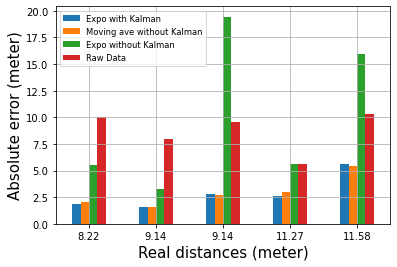

In [17]:
#time window = 120 s
import matplotlib 
a2_errors = [1.86, 1.54, 2.84, 2.64, 5.59]
d2_errors = [2.07, 1.54, 2.7, 2.98, 5.45]
e2_errors = [5.54, 3.31, 19.45, 5.6, 15.99]
raw_errors = [9.99, 7.93, 9.6, 5.61, 10.28]

index = [8.22, 9.14, 9.14, 11.27, 11.58]

df = pd.DataFrame({'Expo with Kalman': a2_errors, 'Moving ave without Kalman': d2_errors, 'Expo without Kalman': e2_errors, 'Raw Data': raw_errors}, index=index)

ax = df.plot.bar(rot=0)
ax.grid()
ax.legend(fontsize='small')
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
ax.set_xlabel("Real distances (meter)", fontsize=15)
ax.set_ylabel("Absolute error (meter)", fontsize=15)
